## 🧹 **0. Unión de información - `unir.py`**

En esta sección, uniremos todos los csv obtenidos a través del web scraping. El código de la función `unir.py` se encarga de juntar todos los csv de la carpeta Seguidores en un nuevo archivo llamado total.csv

```python
# Código de unir.py aquí

In [37]:
import os
import pandas as pd

# Ruta de la carpeta raíz (usando el directorio de trabajo actual)
ruta_base = os.getcwd()

# Ruta de la carpeta donde están los CSV
carpeta_csv = os.path.join(ruta_base, 'Seguidores')

# Lista para almacenar los DataFrames
dataframes = []

# Recorre los archivos en la carpeta Seguidores
for archivo in os.listdir(carpeta_csv):
    if archivo.endswith('.csv'):
        ruta_archivo = os.path.join(carpeta_csv, archivo)
        df = pd.read_csv(ruta_archivo)
        dataframes.append(df)

# Une todos los DataFrames en uno solo
if dataframes:
    total_df = pd.concat(dataframes, ignore_index=True)
    # Guarda el CSV unido directamente en el directorio base
    ruta_total = os.path.join(ruta_base, 'total.csv')
    total_df.to_csv(ruta_total, index=False)
    print(f"CSV unificado guardado como {ruta_total}")
else:
    print("No se encontraron archivos CSV para unir.")

C:\Users\marzabe\AppData\Local\Temp\ipykernel_19768\2585608049.py:17: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo)


CSV unificado guardado como c:\Users\marzabe\OneDrive - UNIVERSIDAD NACIONAL DE INGENIERIA\Mi unidad (martin.zapana.b@uni.pe)\6to Ciclo 2025-1\11vo_Analítica de datos\Semana 4\AnaliticaDeDatos251\total.csv


# 📊 **Uso del Web Scraping para la Obtención de Número de Seguidores de Cuentas de X** 🚀

Este proyecto se centra en la obtención y análisis de los datos de seguidores de cuentas en X utilizando técnicas de web scraping.

---

## 🧹 **1. Limpieza de Datos - `limpiar.py`**

En esta sección, realizamos la limpieza de los datos obtenidos a través del web scraping. El código de la función `limpiar.py` se encarga de eliminar valores nulos, duplicados y corregir cualquier inconsistencia en los datos para asegurar un análisis preciso.

```python
# Código de limpiar.py aquí

In [67]:
import pandas as pd

def limpiar_csv(nombre_csv):
    df = pd.read_csv(nombre_csv)
    df.reset_index(drop=True, inplace=True)

    # Asegurar que las columnas 'Seguidores', 'Tweets', 'Following', 'Goal' sean numéricas
    for columna in ['Seguidores', 'Tweets', 'Following', 'Goal']:
        df[columna] = pd.to_numeric(df[columna], errors='coerce')  # 'coerce' convierte los errores a NaN

    # Regla 1: Eliminar filas donde los 4 campos son 0 simultáneamente
    df = df[~((df['Seguidores'] == 0) & 
              (df['Tweets'] == 0) & 
              (df['Following'] == 0) & 
              (df['Goal'] == 0))].copy()
    df.reset_index(drop=True, inplace=True)

    # Agrupar por 'Usuario' y procesar cada grupo individualmente
    grupos = df.groupby('Usuario', group_keys=False)

    df_limpio = pd.DataFrame()

    for username, grupo in grupos:
        grupo = grupo.reset_index(drop=True)
        i = 0
        while i < len(grupo) - 1:
            fila_actual = grupo.loc[i]
            fila_siguiente = grupo.loc[i + 1]
            eliminar_siguiente = False
            eliminar_actual = False

            # Regla 2: salto brusco entre filas
            for campo in ['Seguidores', 'Tweets', 'Following', 'Goal']:
                if abs(fila_siguiente[campo] - fila_actual[campo]) > fila_actual[campo]:
                    eliminar_siguiente = True
                    break

            # Regla 3: eliminar bloque de 0s si luego hay un valor > 10000
            indices_para_eliminar = []
            for campo in ['Seguidores', 'Tweets', 'Following', 'Goal']:
                if fila_actual[campo] == 0:
                    j = i
                    while j < len(grupo) and grupo.loc[j][campo] == 0:
                        indices_para_eliminar.append(j)
                        j += 1
                    if j < len(grupo) and grupo.loc[j][campo] > 10000:
                        eliminar_actual = True
                        break

            if eliminar_actual:
                grupo.drop(index=indices_para_eliminar, inplace=True)
                grupo.reset_index(drop=True, inplace=True)
                # No avanzamos 'i' porque la estructura cambió
            elif eliminar_siguiente:
                grupo.drop(index=i + 1, inplace=True)
                grupo.reset_index(drop=True, inplace=True)
                # No avanzamos 'i' porque la estructura cambió
            else:
                i += 1  # Solo avanzamos si no eliminamos nada

        # Regla 4: eliminar última fila si cumple condición
        if len(grupo) >= 2:
            ultima = grupo.loc[len(grupo) - 1]
            penultima = grupo.loc[len(grupo) - 2]
            for campo in ['Seguidores', 'Tweets', 'Following', 'Goal']:
                if ultima[campo] == 0 and penultima[campo] > 10000:
                    grupo.drop(index=len(grupo) - 1, inplace=True)
                    grupo.reset_index(drop=True, inplace=True)
                    print(f"⚠ Última fila eliminada por Regla 4 para '{username}' en campo '{campo}'")
                    break

        # Añadir el grupo limpio
        df_limpio = pd.concat([df_limpio, grupo], ignore_index=True)

    # Guardar el nuevo CSV
    nuevo_nombre = nombre_csv.replace('.csv', '_limpio.csv')
    df_limpio.to_csv(nuevo_nombre, index=False)
    print(f"✅ Guardado como: {nuevo_nombre}")

In [68]:
limpiar_csv("total.csv")

C:\Users\marzabe\AppData\Local\Temp\ipykernel_19768\3447242290.py:4: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(nombre_csv)


⚠ Última fila eliminada por Regla 4 para '@canaln_' en campo 'Tweets'
⚠ Última fila eliminada por Regla 4 para '@cuarto_poder' en campo 'Tweets'
⚠ Última fila eliminada por Regla 4 para '@espnfc' en campo 'Goal'
⚠ Última fila eliminada por Regla 4 para '@informacosmos' en campo 'Goal'
⚠ Última fila eliminada por Regla 4 para '@realdonaldtrump' en campo 'Goal'
⚠ Última fila eliminada por Regla 4 para '@uniceflac' en campo 'Tweets'
✅ Guardado como: total_limpio.csv


## 📈 **2. Análisis Exploratorio de Datos - `aed.py`** 🔍

En esta sección, realizamos un análisis exhaustivo de los datos obtenidos para entender patrones, relaciones y comportamientos clave. El análisis exploratorio de datos (AED) nos ayuda a identificar tendencias y correlaciones significativas entre las diferentes variables.

- **Objetivo**: Explorar los datos mediante estadísticas descriptivas, análisis de correlación y técnicas de detección de anomalías para extraer conclusiones valiosas que guíen la toma de decisiones.

### Técnicas Utilizadas:
1. **Estadísticas Descriptivas**: Calculo de métricas clave como la media, mediana, desviación estándar y otros valores estadísticos que nos permiten tener una primera comprensión de los datos.
2. **Correlación entre Variables**: Investigamos las relaciones entre las variables, como el número de seguidores y la actividad de las cuentas.
3. **Detección de Outliers**: Identificamos registros atípicos o fuera de lo común en los datos, lo que puede indicar comportamientos interesantes o errores en el scraping.

```python
# Código de aed.py aquí


In [56]:
import pandas as pd

def analizar_datos_csv(usuario=None):
    # Cargar el archivo unido, asegurando que las columnas tengan el tipo de dato correcto
    df = pd.read_csv('./total_limpio.csv', parse_dates=["Hora"], low_memory=False)

    # Convertir las columnas 'Tweets', 'Following' y 'Goal' a int64
    df['Tweets'] = df['Tweets'].astype('int64', errors='ignore')  # 'errors=ignore' para no afectar si hay datos incompatibles
    df['Following'] = df['Following'].astype('int64', errors='ignore')
    df['Goal'] = df['Goal'].astype('int64', errors='ignore')

    if usuario:
        # Filtrar por el usuario dado
        df = df[df['Usuario'] == usuario]  # Asegúrate de pasar un nombre de usuario válido
        if df.empty:
            print(f"⚠️ No se encontraron datos para el usuario: {usuario}")
            return
        print(f"📊 Análisis de datos para el usuario: {usuario}")
    else:
        print(f"📊 Análisis de datos para todos los usuarios (agrupados)")

    # -----------------------------
    # Dimensiones y tipos de datos
    # -----------------------------
    print("\n🔹 Dimensiones del DataFrame:", df.shape)
    print("\n🔹 Tipos de datos:")
    print(df.dtypes)

    # -----------------------------
    # Primeras y últimas filas
    # -----------------------------
    print("\n🔹 Primeras filas:")
    print(df.head())
    print("\n🔹 Últimas filas:")
    print(df.tail())

    # -----------------------------
    # Valores nulos
    # -----------------------------
    print("\n🔹 Valores nulos por columna:")
    print(df.isnull().sum())

    # -----------------------------
    # Estadísticas descriptivas
    # -----------------------------
    if usuario:
        print("\n🔹 Estadísticas descriptivas (usuario único):")
        print(df.describe())
    else:
        print("\n🔹 Estadísticas descriptivas agrupadas por usuario:")
        agrupado = df.groupby('Usuario')[['Seguidores', 'Tweets', 'Following', 'Goal']].describe()
        print(agrupado)

    # -----------------------------
    # Valores únicos por campo
    # -----------------------------
    print("\n🔹 Valores únicos por campo:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} únicos")

    # -----------------------------
    # Moda, rango y outliers
    # -----------------------------
    numericas = ['Seguidores', 'Tweets', 'Following', 'Goal']

    if usuario:
        # Si es un usuario específico
        for col in numericas:
            print(f"\n🔸 Estadísticas para: {col}")
            print(f"  • Moda: {df[col].mode().iloc[0]}")
            print(f"  • Rango: {df[col].max() - df[col].min()}")
            
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
            print(f"  • Posibles outliers: {len(outliers)}")
    else:
        # Si es para todos, agrupando por usuario
        for col in numericas:
            print(f"\n🔸 Estadísticas agrupadas para: {col}")
            moda = df.groupby('Usuario')[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
            rango = df.groupby('Usuario')[col].agg(lambda x: x.max() - x.min())
            print(f"  • Moda por usuario:\n{moda}")
            print(f"\n  • Rango por usuario:\n{rango}")

In [57]:
analizar_datos_csv()

📊 Análisis de datos para todos los usuarios (agrupados)

🔹 Dimensiones del DataFrame: (1983396, 6)

🔹 Tipos de datos:
Hora          datetime64[ns]
Usuario               object
Seguidores             int64
Tweets                 int64
Following              int64
Goal                   int64
dtype: object

🔹 Primeras filas:
                 Hora       Usuario  Seguidores  Tweets  Following  Goal
0 2025-04-24 16:30:34  @atu_gobperu       54632   11842        511  5368
1 2025-04-24 16:30:36  @atu_gobperu       54632   11842        511  5368
2 2025-04-24 16:30:38  @atu_gobperu       54632   11842        511  5368
3 2025-04-24 16:30:41  @atu_gobperu       54632   11842        511  5368
4 2025-04-24 16:30:43  @atu_gobperu       54632   11842        511  5368

🔹 Últimas filas:
                       Hora    Usuario  Seguidores  Tweets  Following   Goal
1983391 2025-04-25 22:38:02  @willaxtv      768037  274520       1026  31963
1983392 2025-04-25 22:38:04  @willaxtv      768037  274520       

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def matriz_correlacion(nombre_csv='total_limpio.csv', username=None, guardar_imagen=False):
    # Cargar datos
    df = pd.read_csv(nombre_csv)
    
    # Limpiar columnas (por si acaso)
    df.columns = df.columns.str.strip()

    # Columnas a considerar
    columnas_interes = ['Seguidores', 'Tweets', 'Following', 'Goal']
    
    # Asegurarse de que las columnas de interés sean numéricas
    for columna in columnas_interes:
        df[columna] = pd.to_numeric(df[columna], errors='coerce')  # Convierte a numérico, reemplaza errores con NaN

    # Función interna para graficar
    def graficar(df_usuario, nombre_usuario):
        matriz_corr = df_usuario[columnas_interes].corr()

        plt.figure(figsize=(8, 6))
        sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)
        plt.title(f"Matriz de Correlación para {nombre_usuario}", fontsize=14)
        plt.tight_layout()

        if guardar_imagen:
            nombre_imagen = f"correlacion_{nombre_usuario[1:]}.png"  # Quitar @ del nombre
            plt.savefig(nombre_imagen)
            print(f"✅ Imagen guardada como {nombre_imagen}")
        else:
            plt.show()

        plt.close()

    # Si se especifica un usuario, procesar solo ese
    if username:
        df_usuario = df[df['Usuario'] == username]
        if not df_usuario.empty:
            graficar(df_usuario, username)
        else:
            print(f"⚠ Usuario '{username}' no encontrado en el CSV.")
    else:
        # Sino, procesar todos los usuarios
        usuarios = df['Usuario'].unique()
        for usuario in usuarios:
            df_usuario = df[df['Usuario'] == usuario]
            if not df_usuario.empty:
                graficar(df_usuario, usuario)

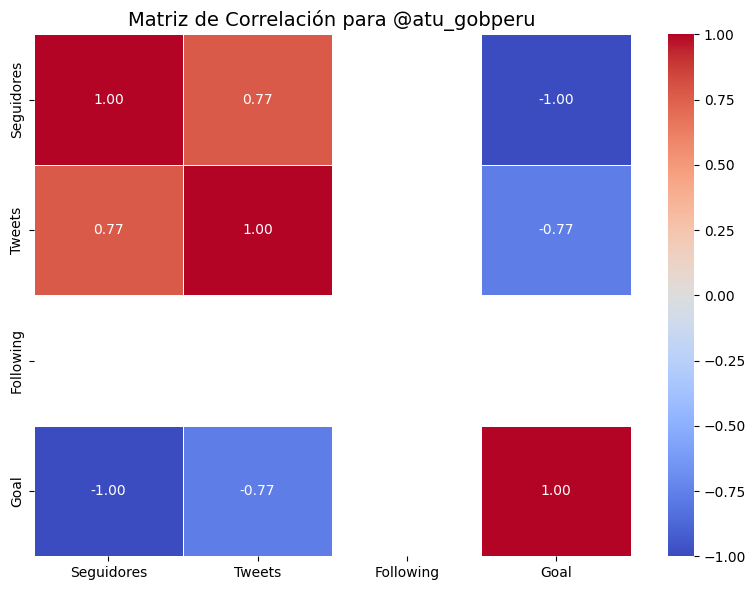

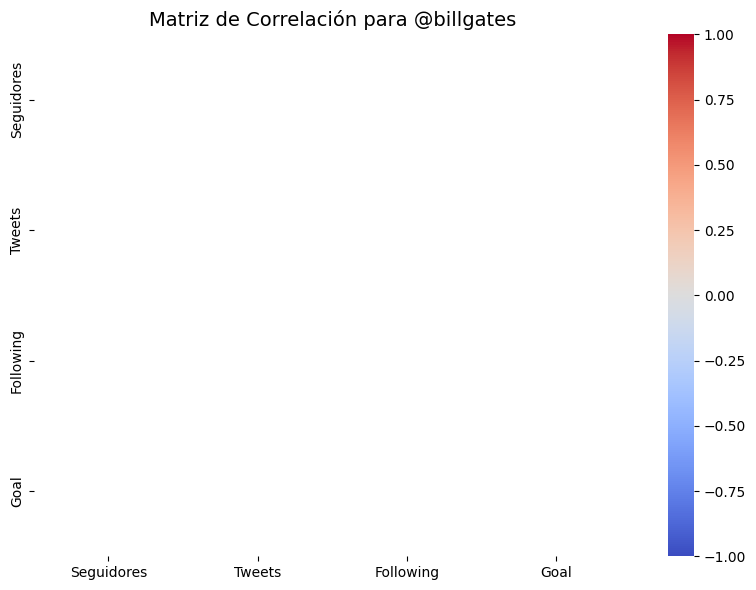

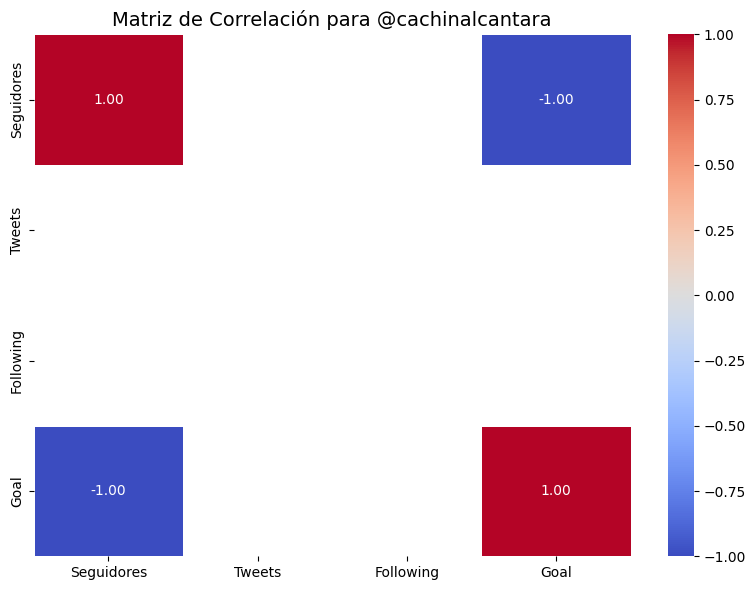

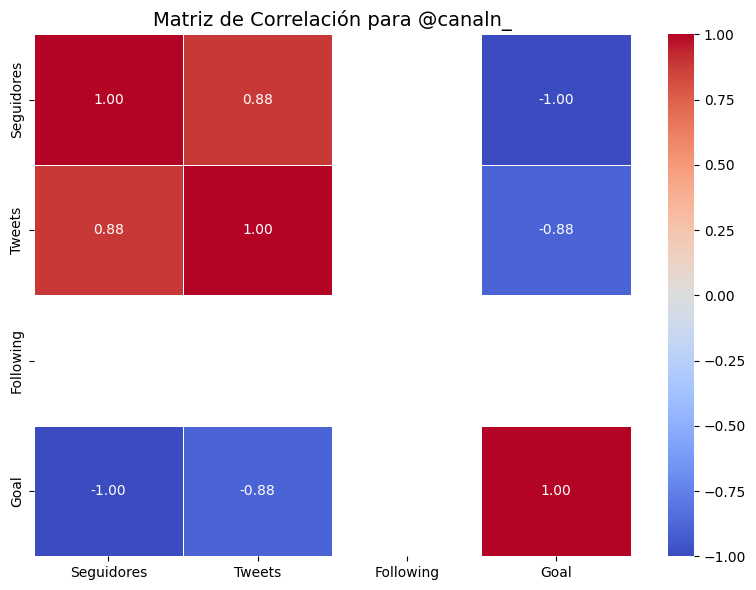

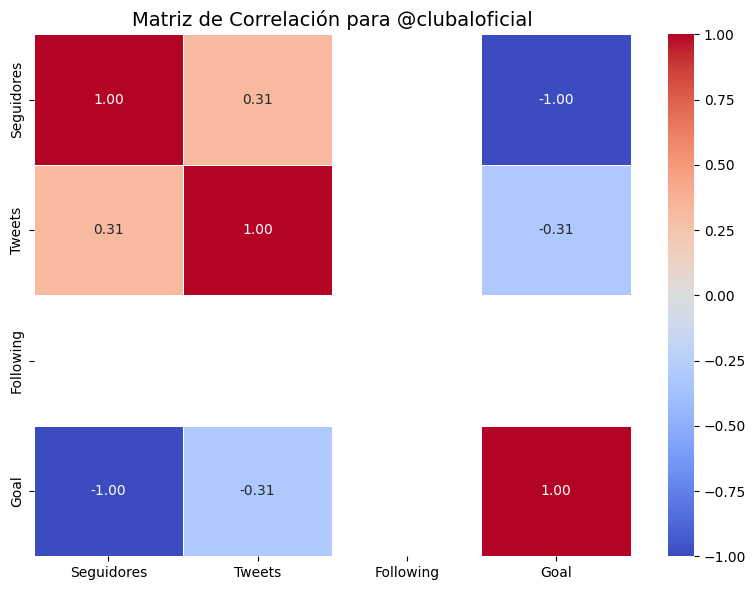

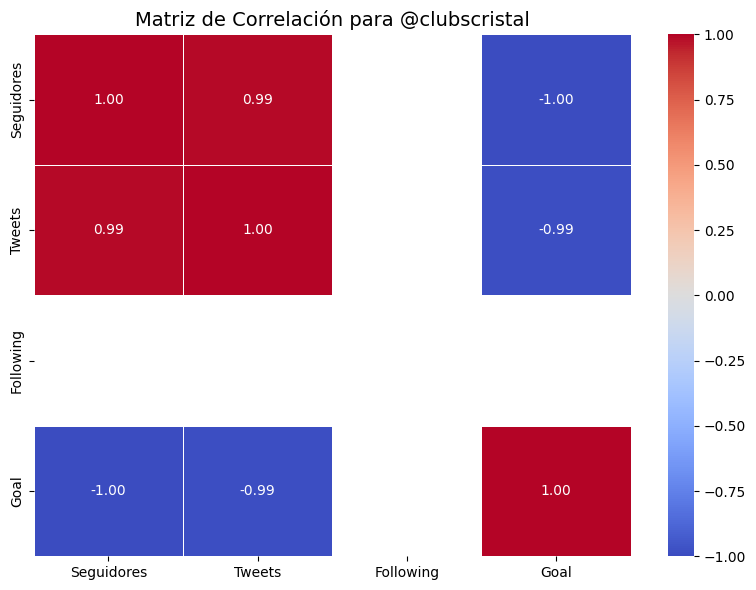

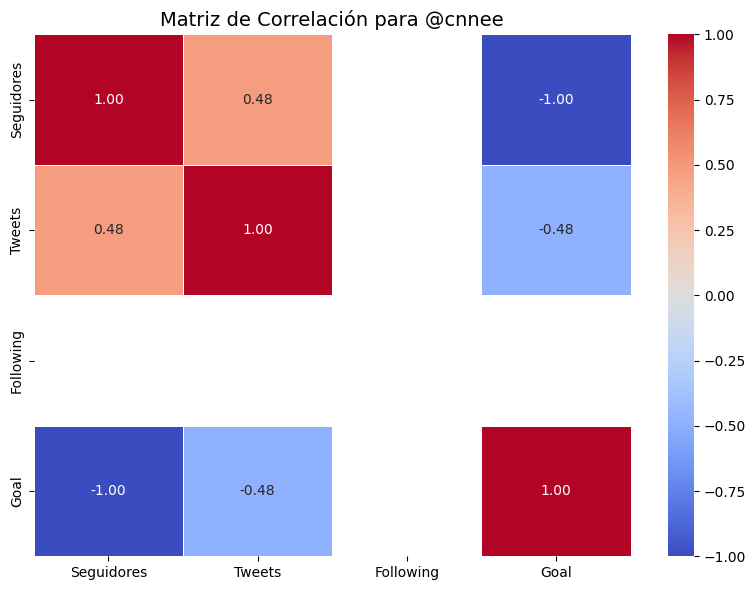

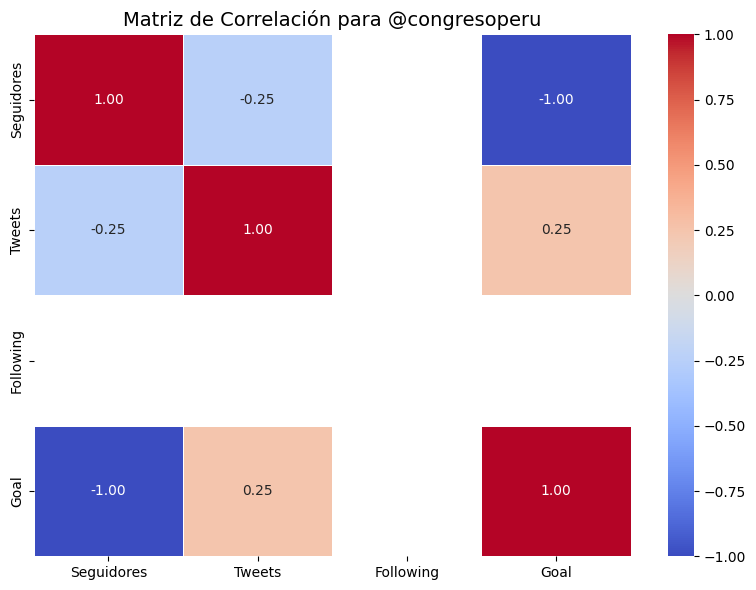

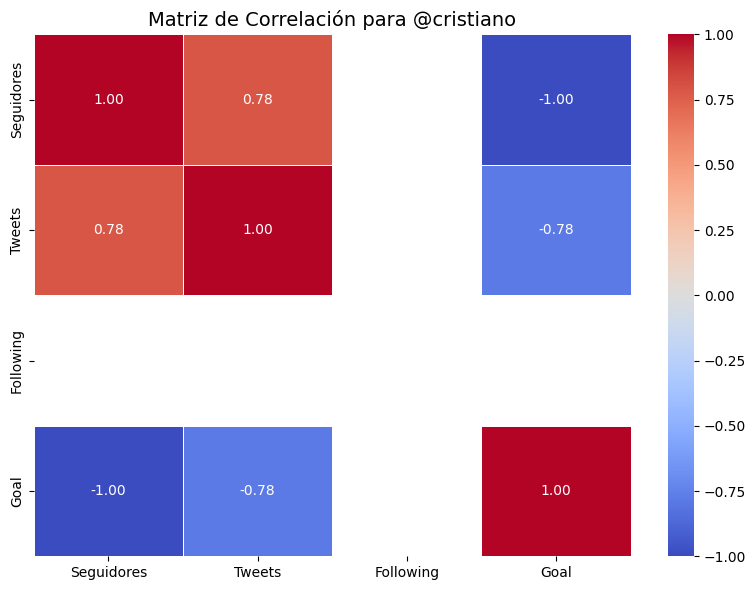

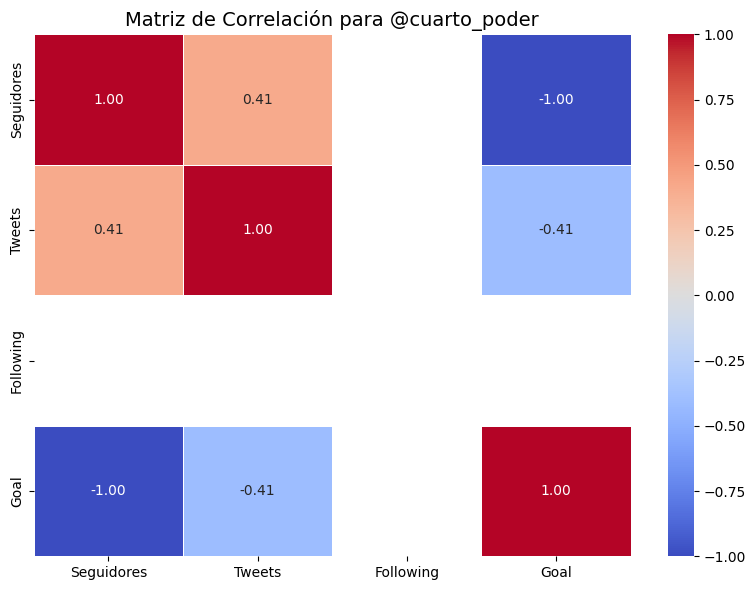

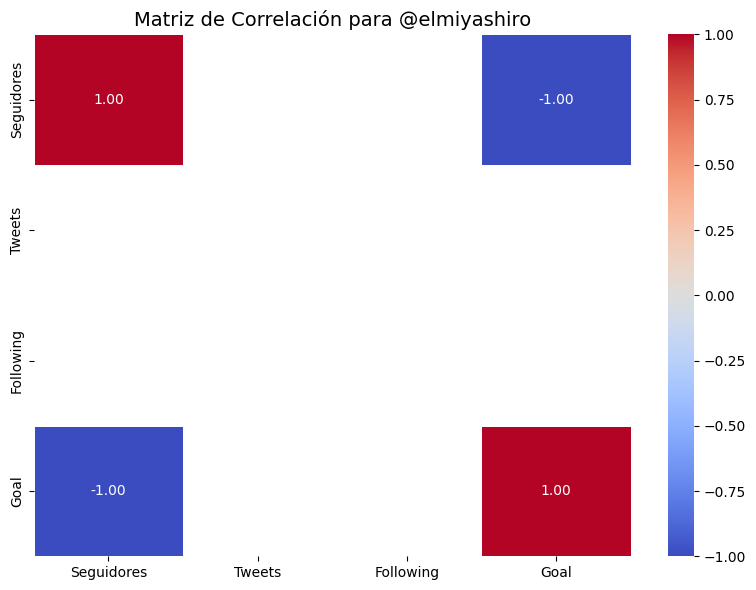

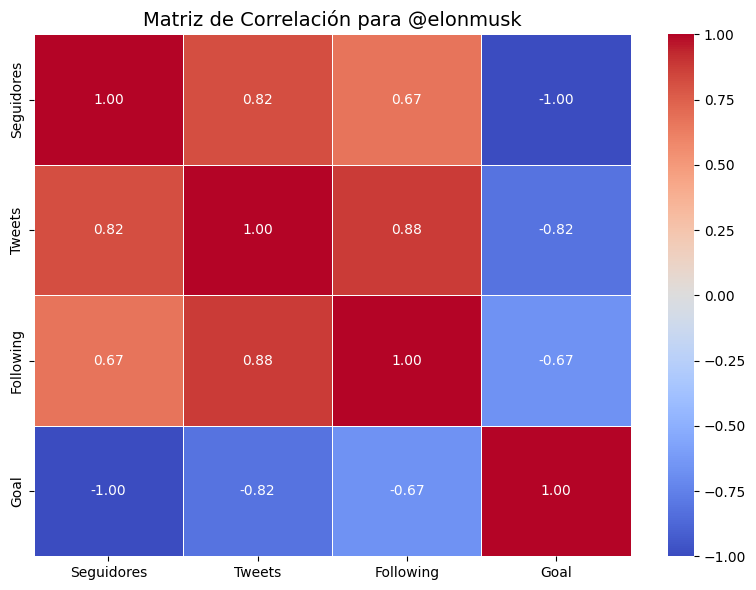

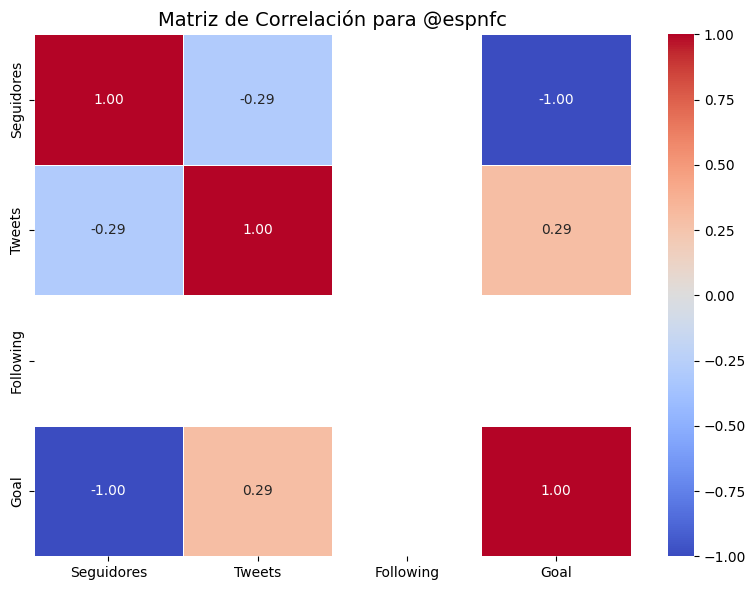

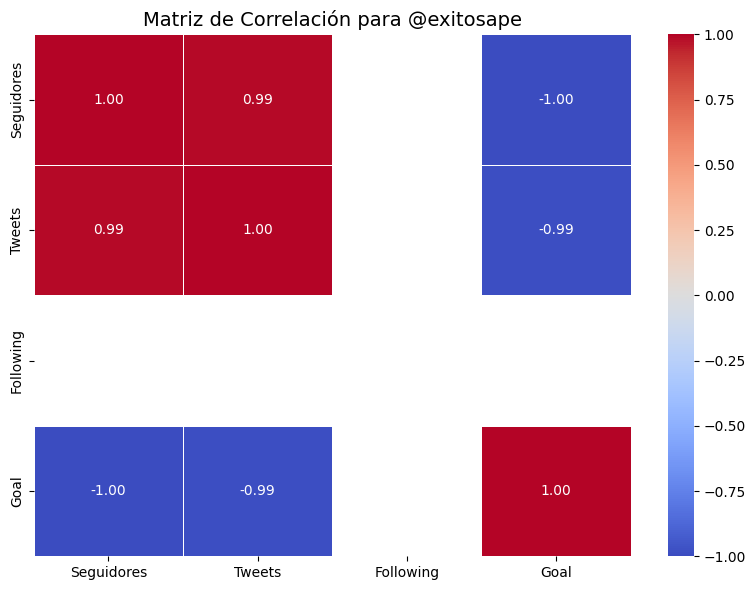

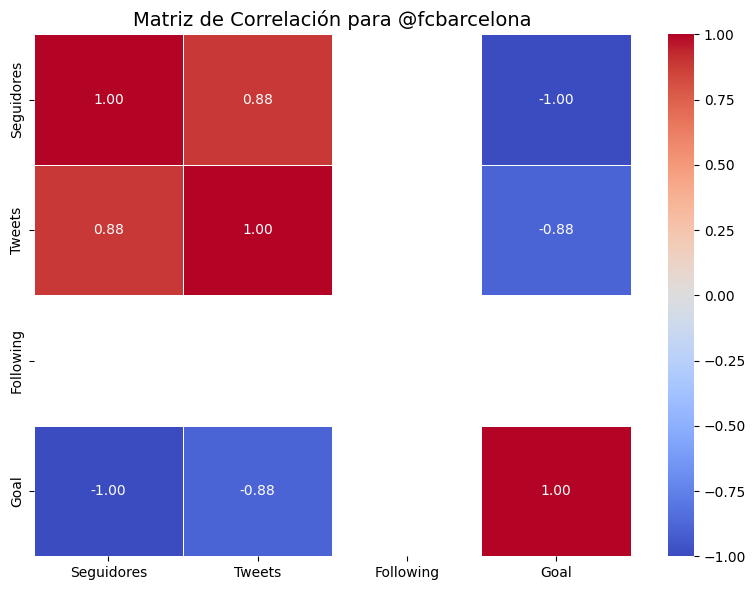

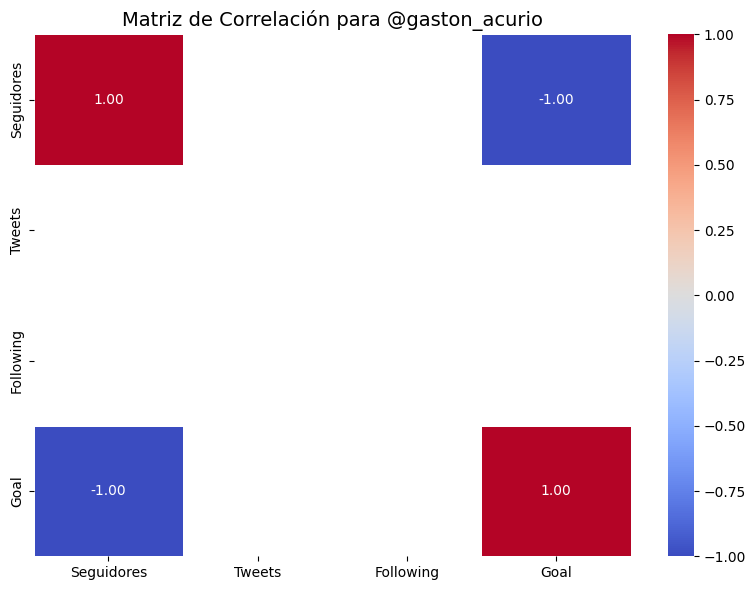

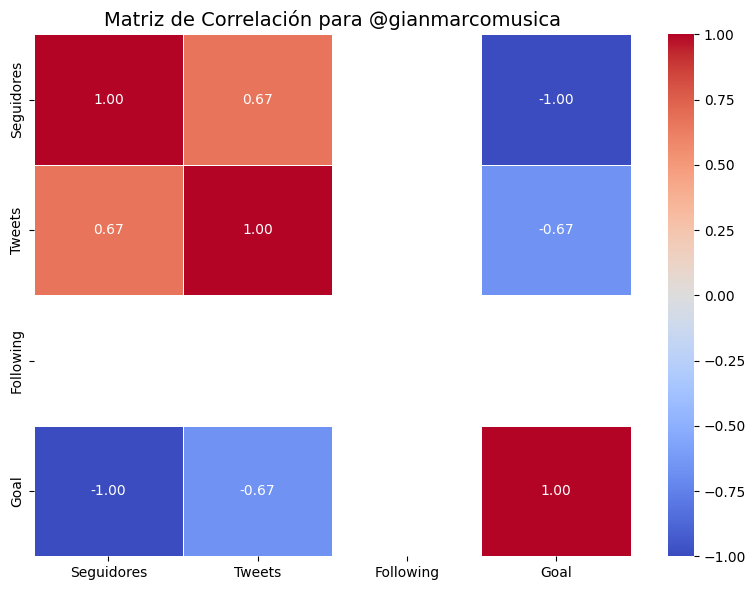

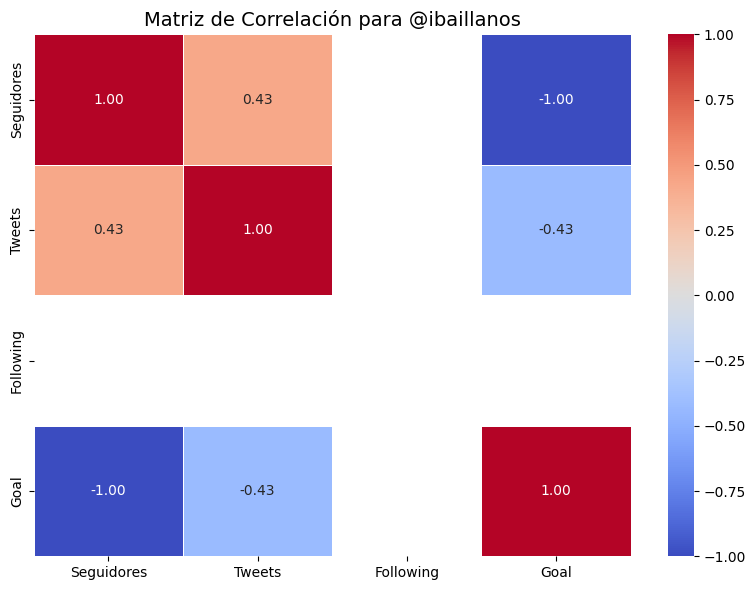

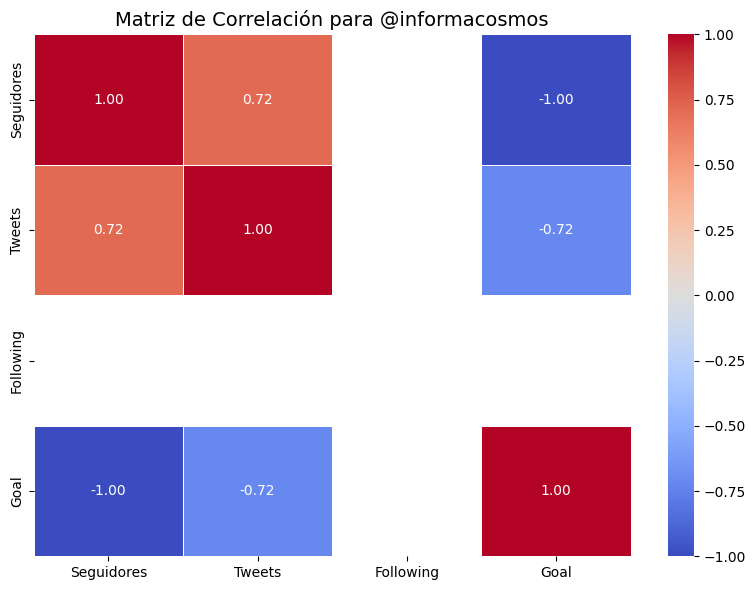

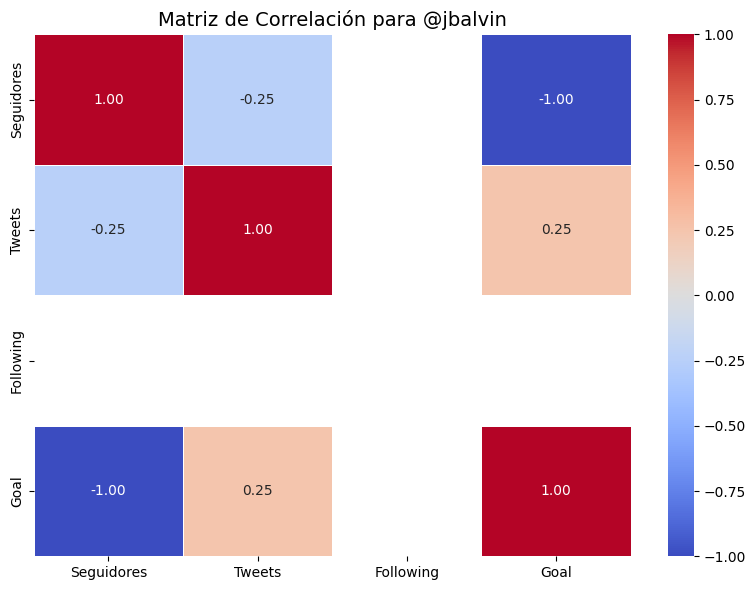

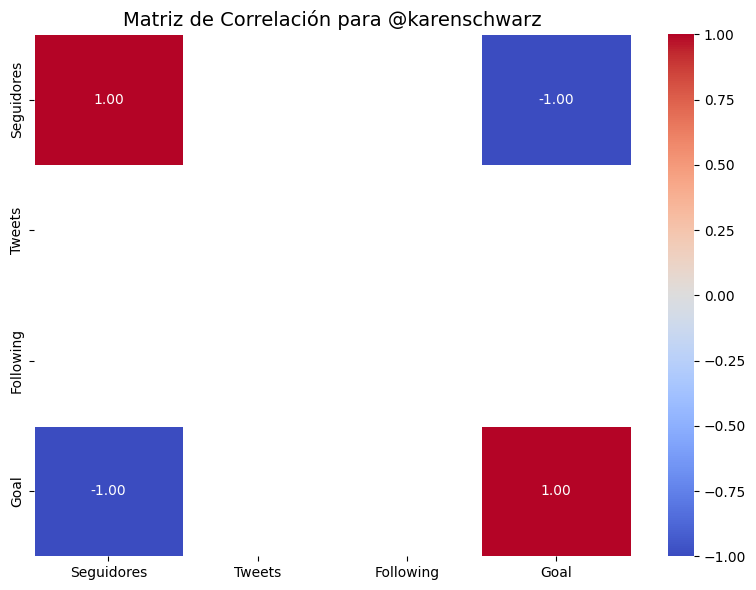

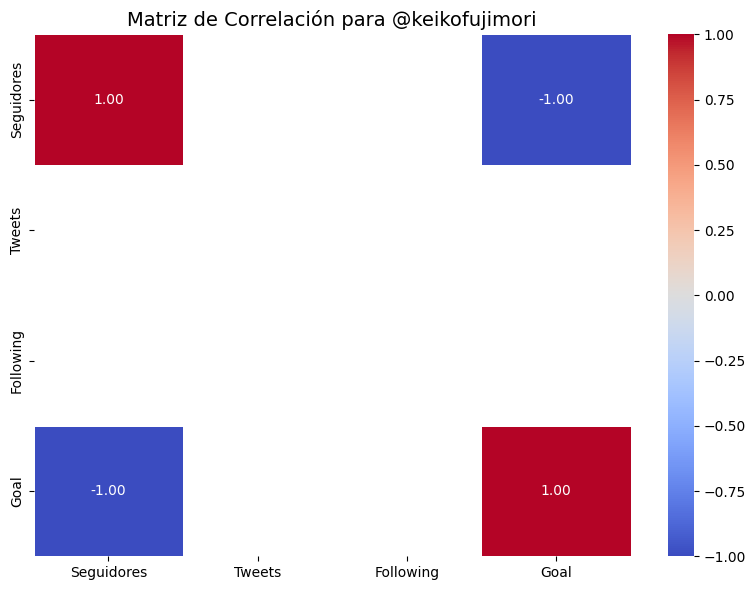

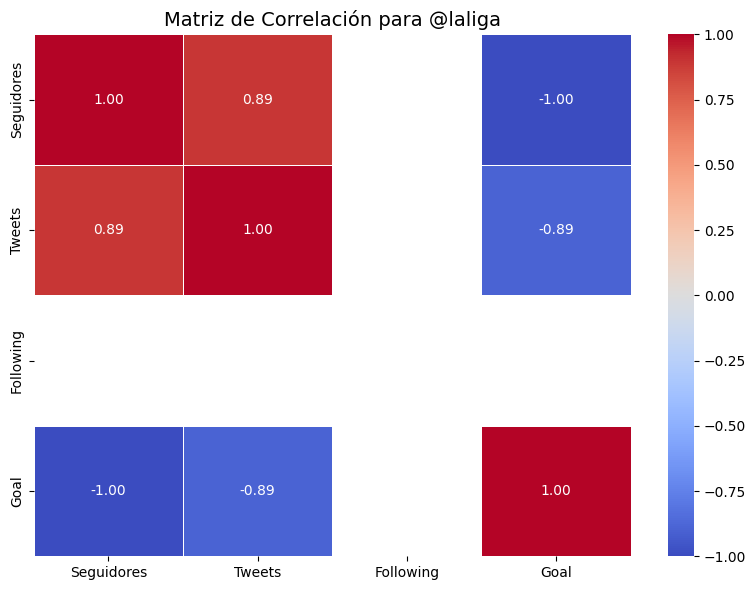

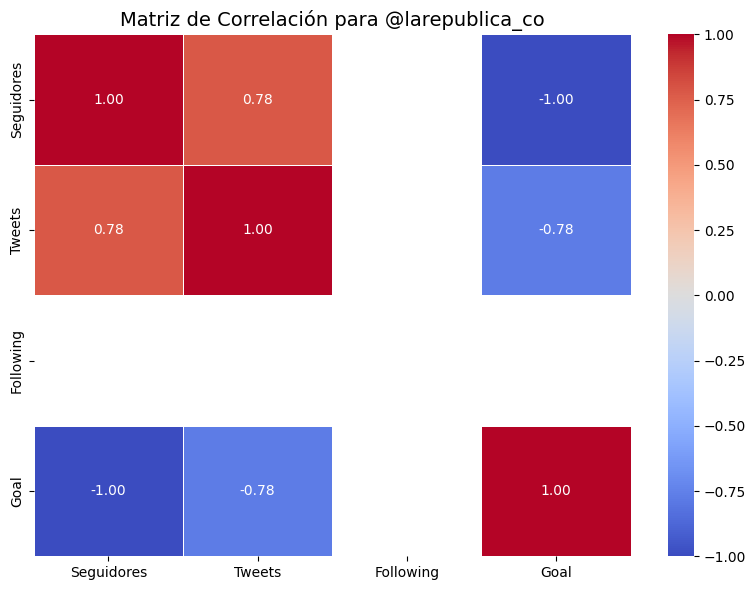

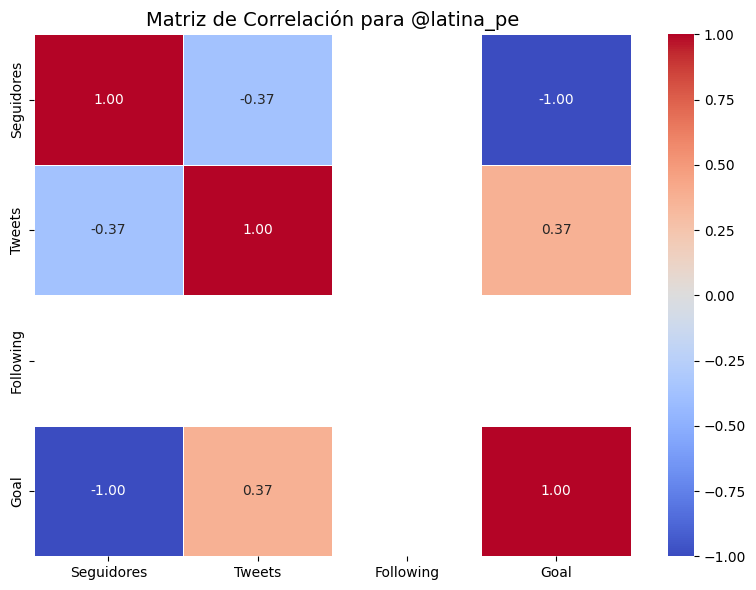

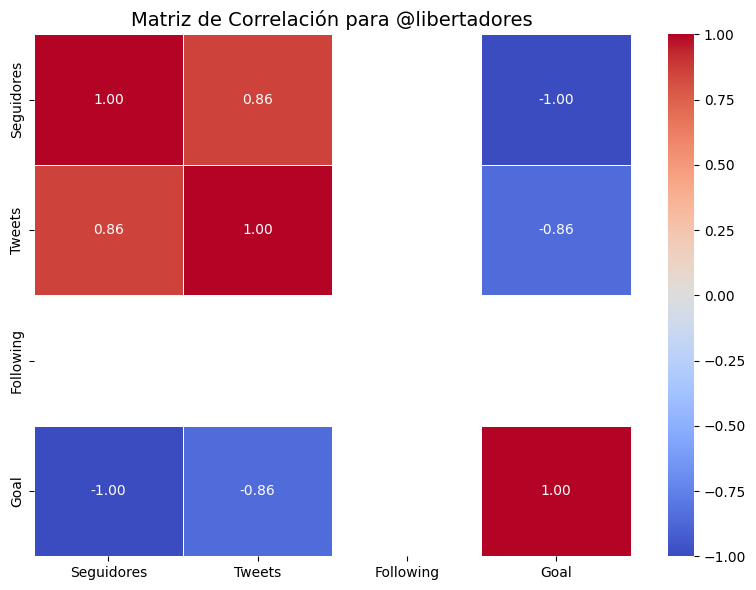

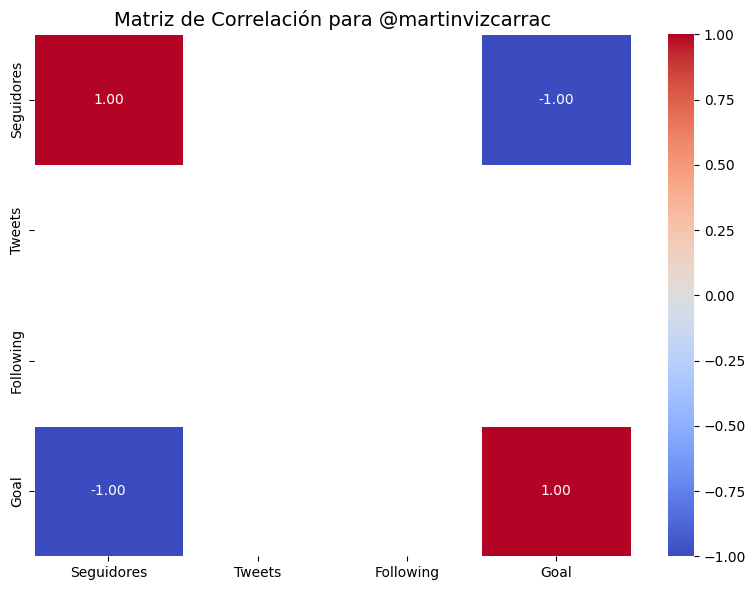

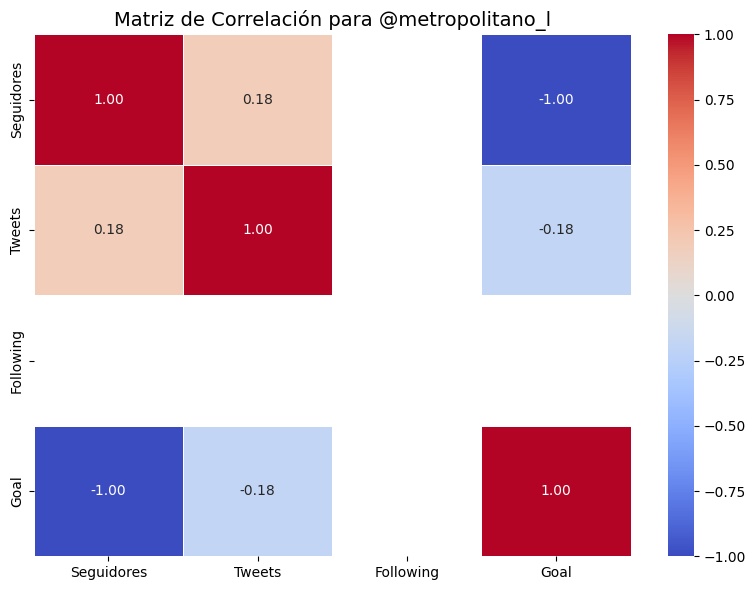

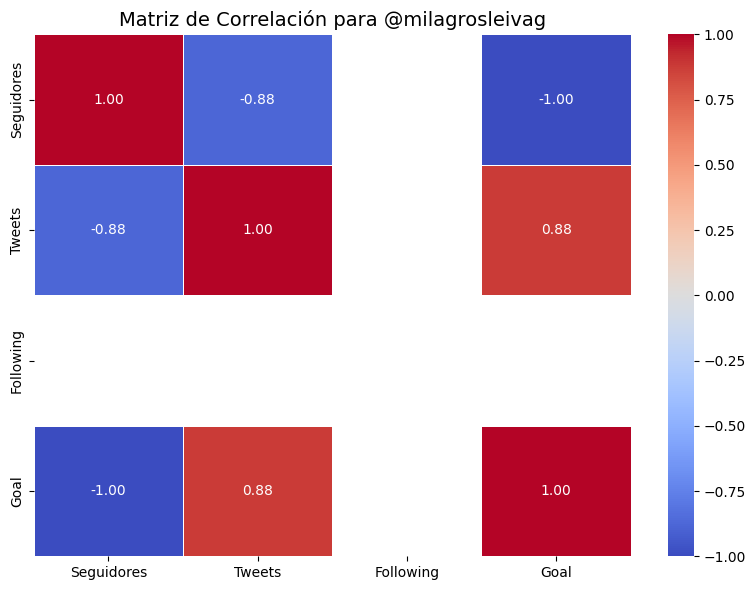

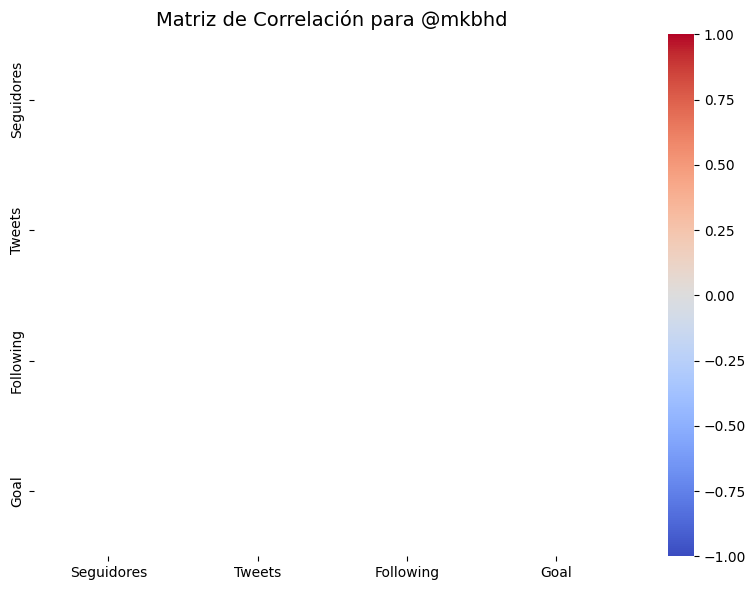

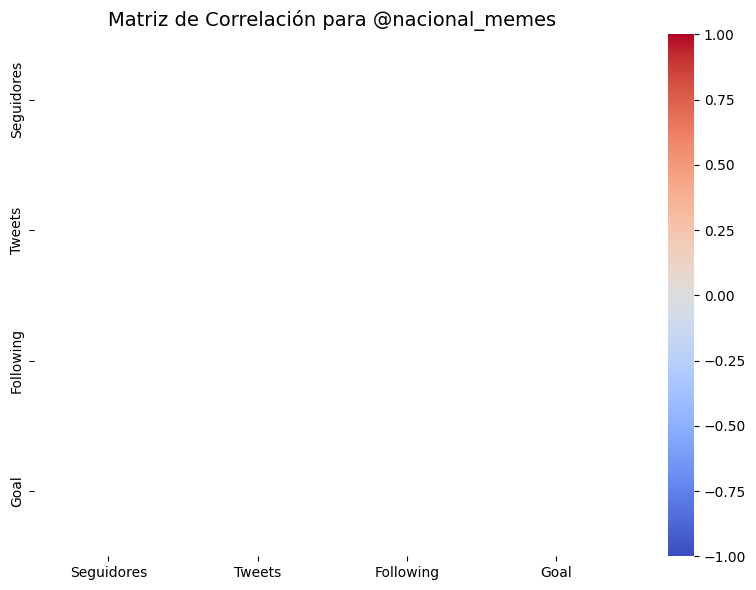

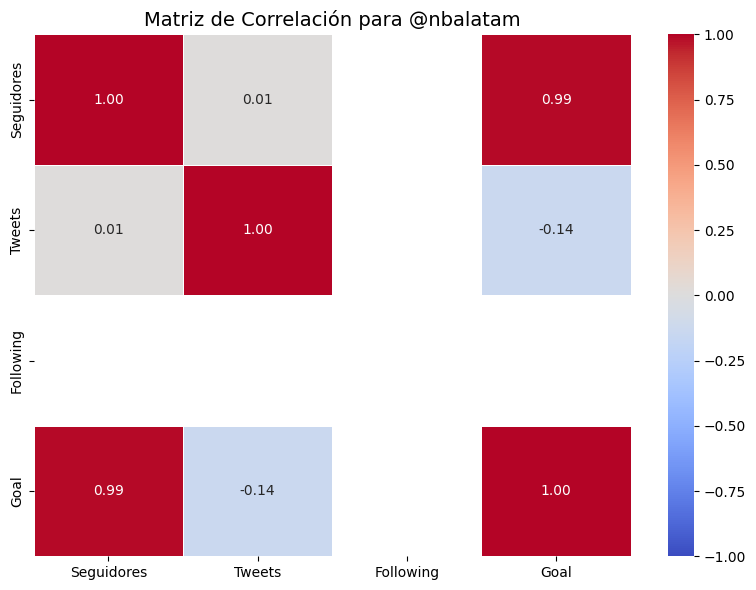

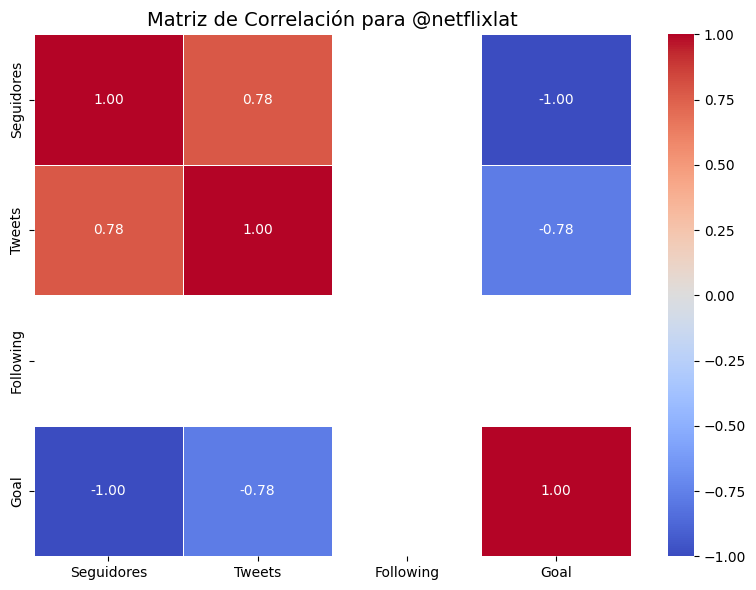

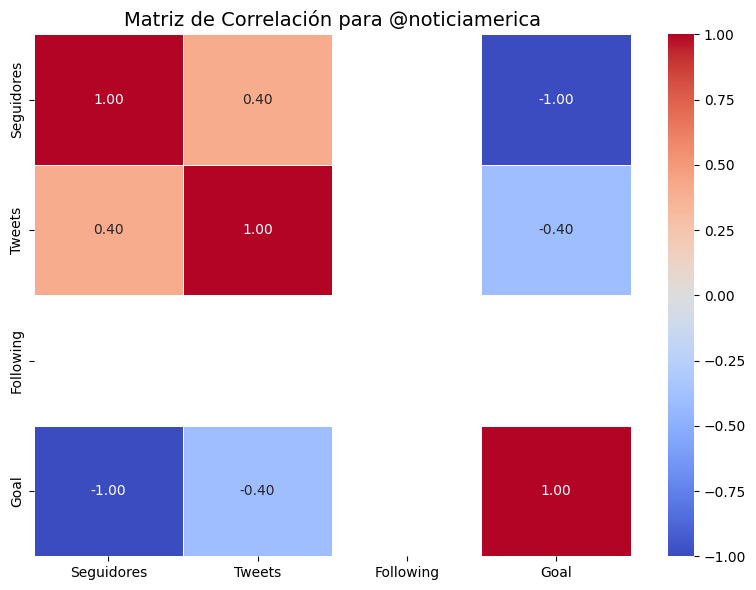

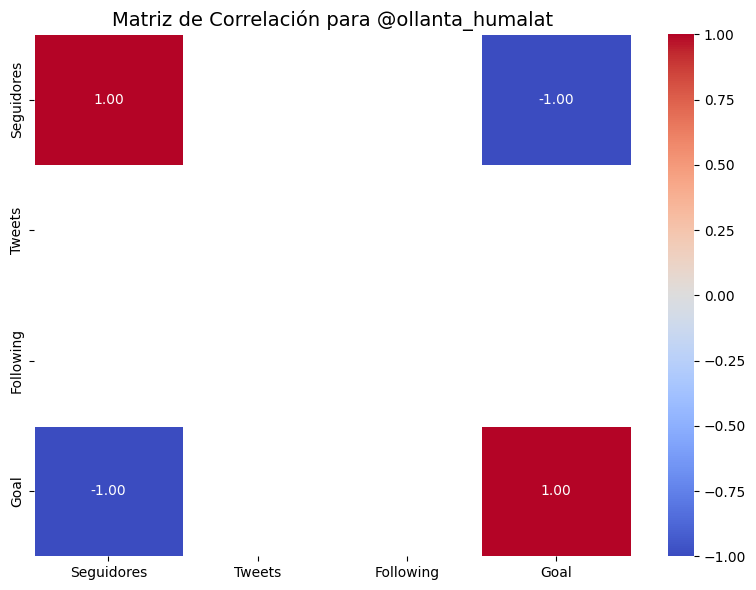

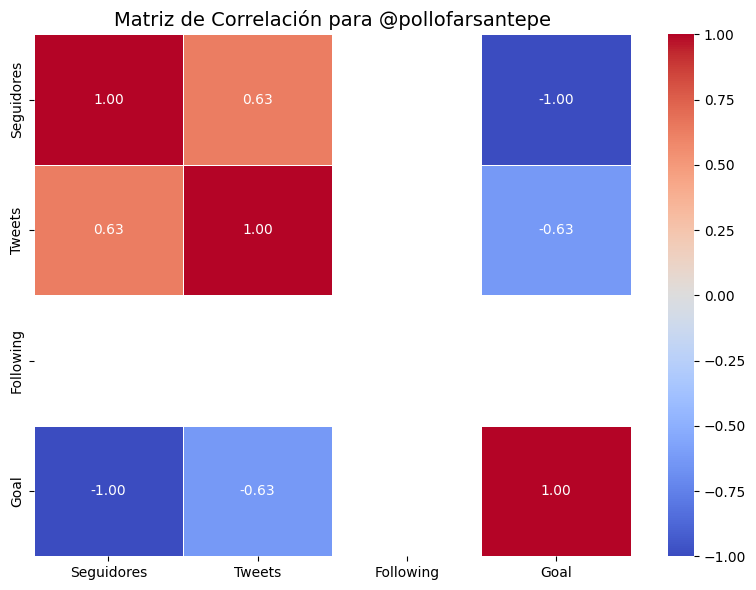

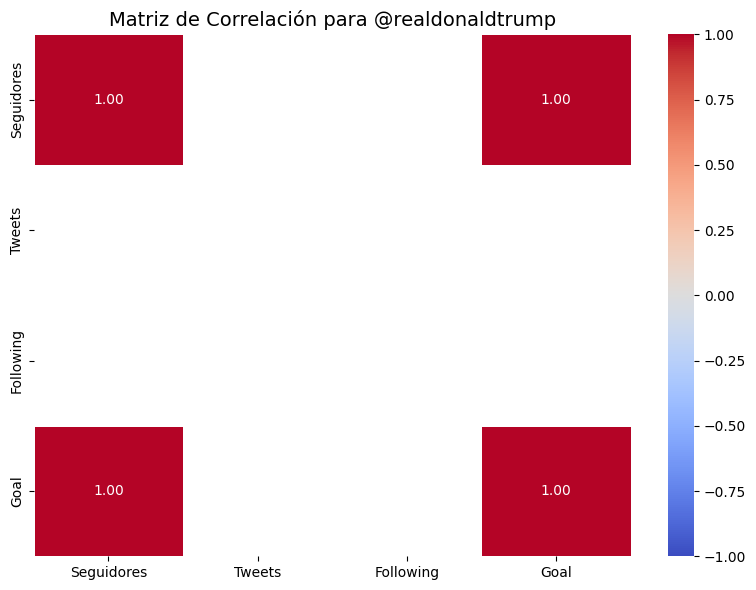

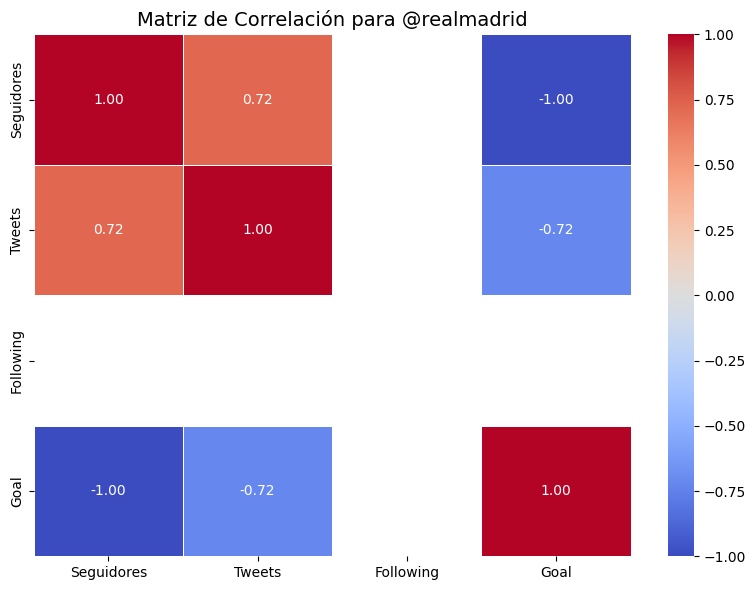

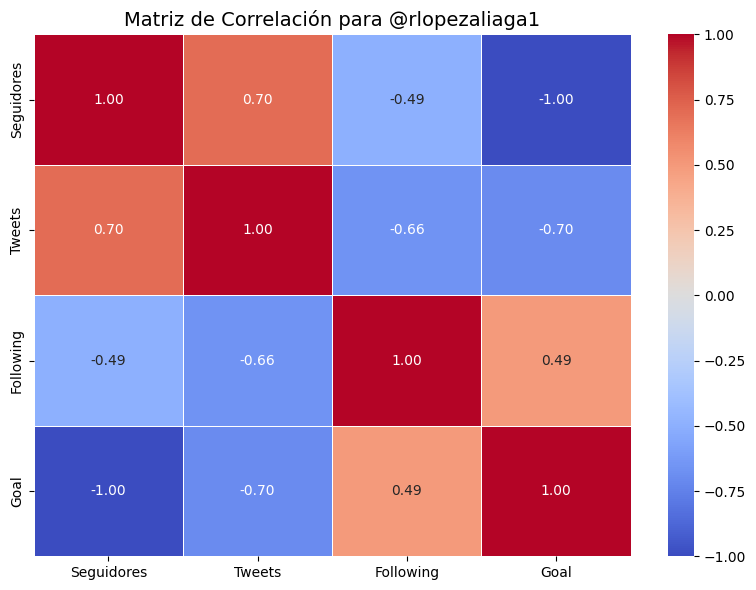

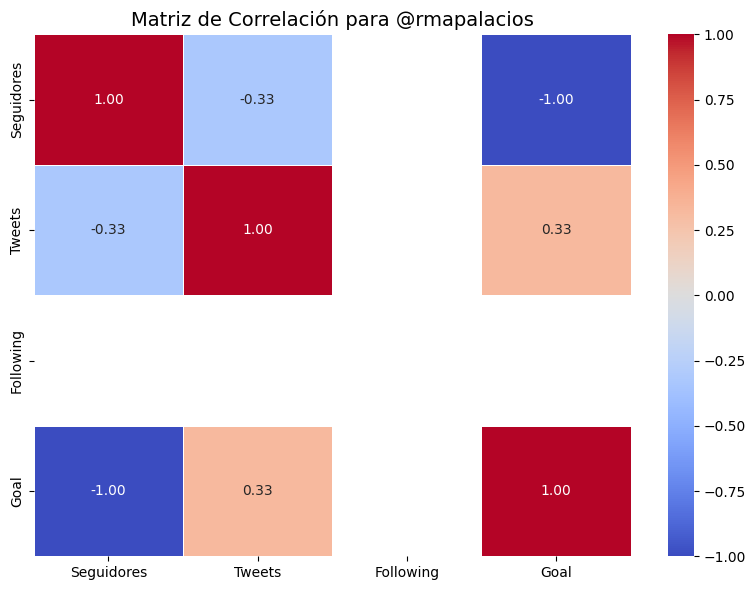

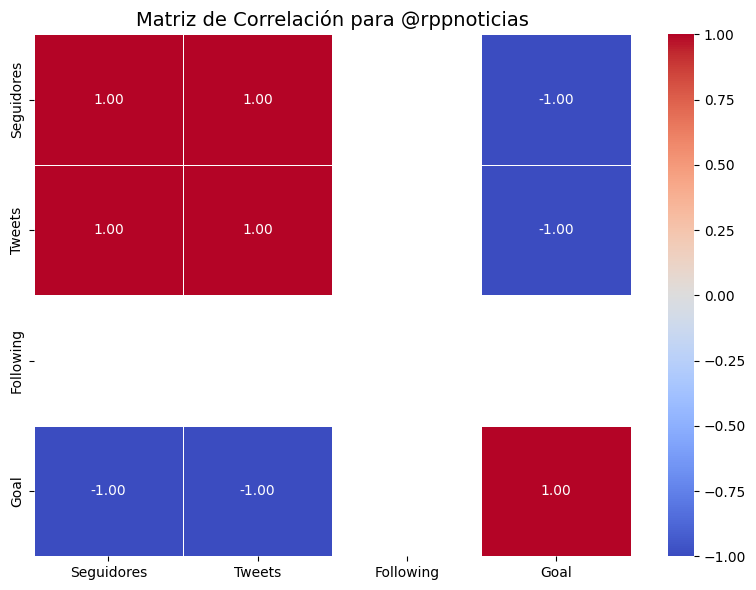

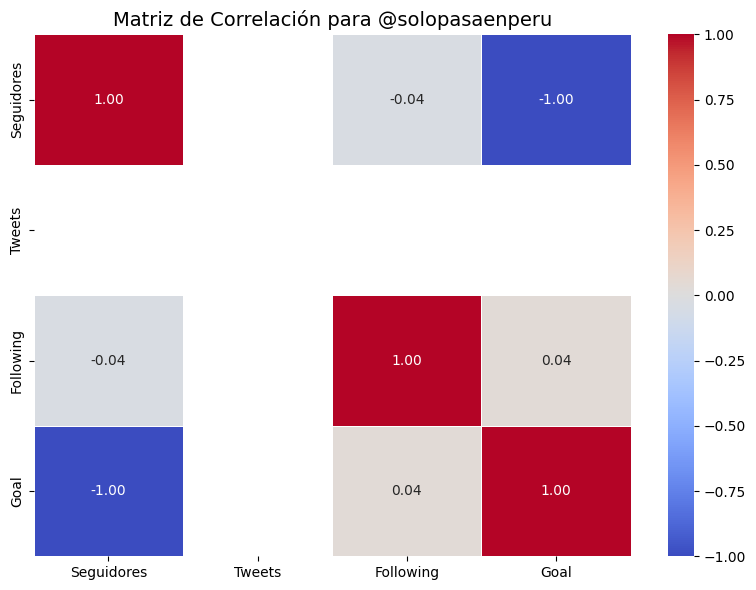

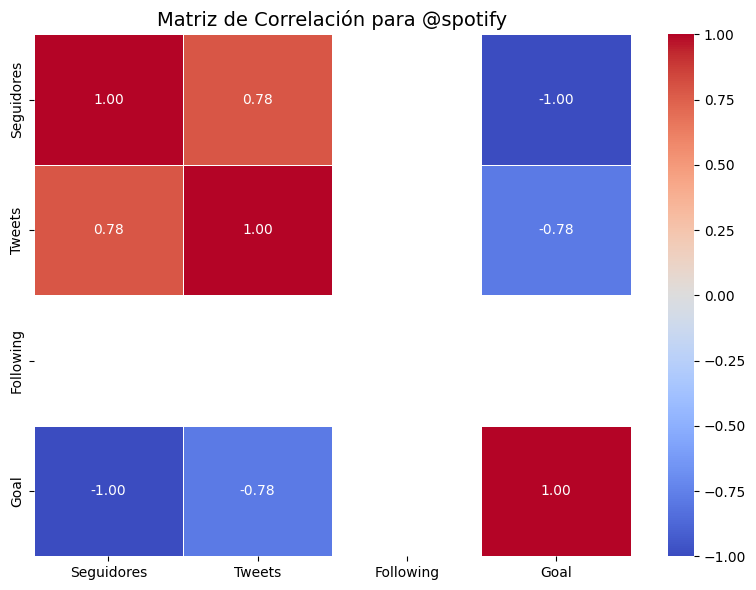

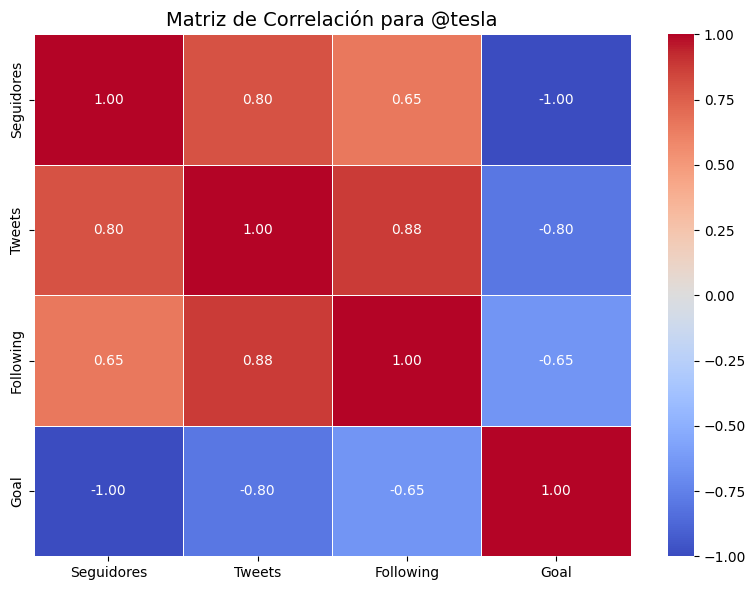

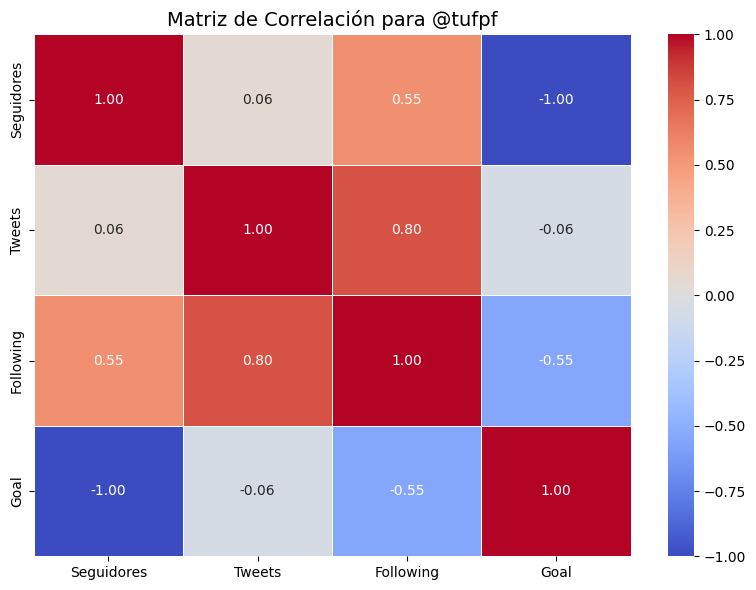

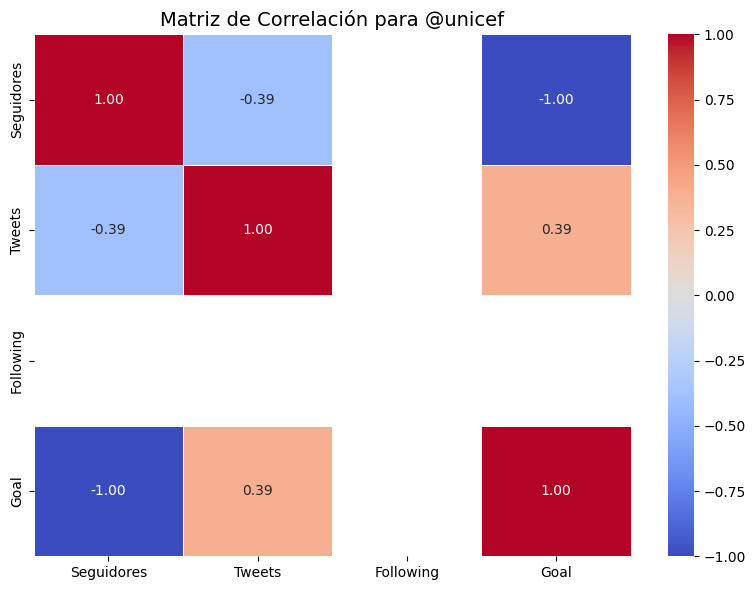

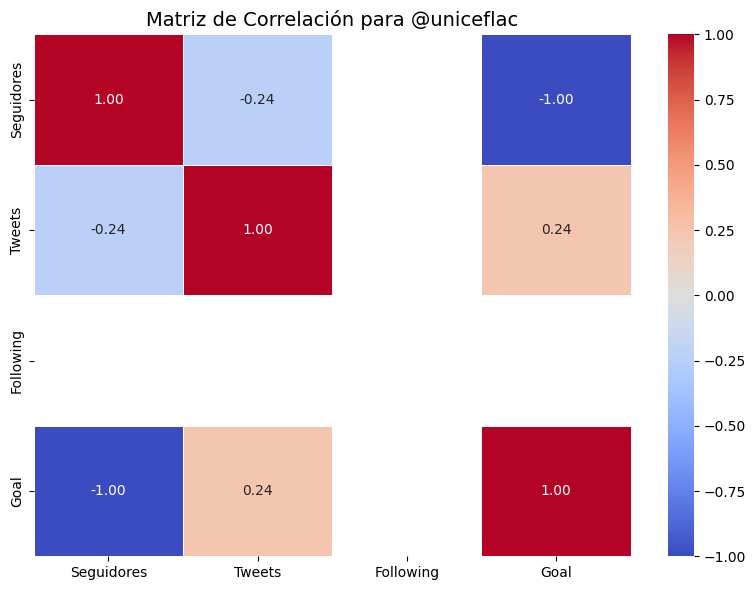

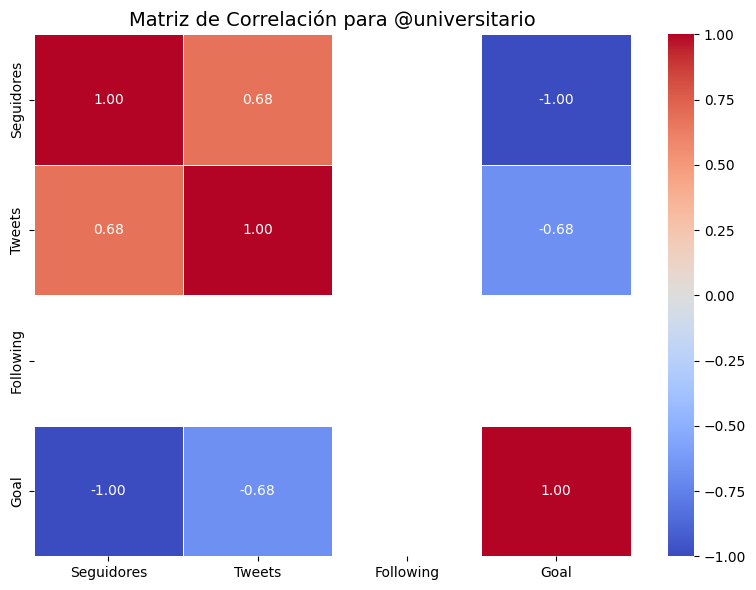

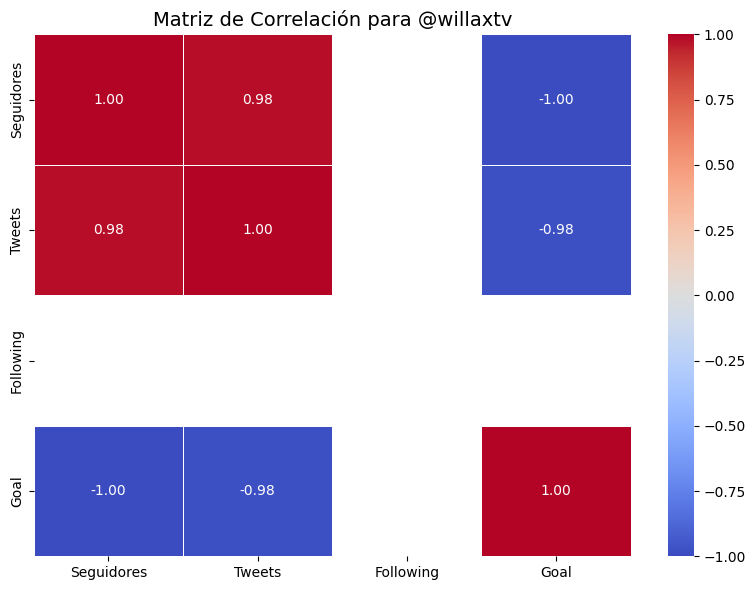

In [87]:
matriz_correlacion()

## 📊 **3. Visualización de Datos - `graficos.py`** 🎨

En esta sección, creamos gráficos para representar las tendencias de los seguidores de las cuentas de X. Utilizamos diversas herramientas de visualización para facilitar el análisis de los datos obtenidos en la etapa anterior.

- **Objetivo**: Generar gráficos interactivos y estáticos que muestren las relaciones entre los seguidores y otras variables relevantes, como el tiempo, la actividad de las cuentas, etc.

### Gráficos Generados:
1. **Gráfico de Seguidores a lo Largo del Tiempo**: Muestra la evolución de seguidores de las cuentas de X.
2. **Gráfico de Distribución de Seguidores**: Representa la distribución de los seguidores entre las diferentes cuentas.

```python
# Código de graficos.py aquí

In [69]:
import os
import pandas as pd
from matplotlib import pyplot as plt

def graficar_serie_seguidores(nombre_csv, usuario=None, hora_inicio=None, hora_fin=None, guardar=False):
    # Leer y preparar los datos
    df = pd.read_csv(nombre_csv)
    df['Hora'] = pd.to_datetime(df['Hora'])
    df = df.sort_values('Hora')

    # Si no hay hora_inicio o hora_fin, usar los extremos
    if hora_inicio is None:
        hora_inicio = df['Hora'].min()
    else:
        hora_inicio = pd.to_datetime(hora_inicio)
        
    if hora_fin is None:
        hora_fin = df['Hora'].max()
    else:
        hora_fin = pd.to_datetime(hora_fin)

    # Filtrar por el rango de tiempo
    mask_tiempo = (df['Hora'] >= hora_inicio) & (df['Hora'] <= hora_fin)
    df = df.loc[mask_tiempo]

    if df.empty:
        print("⚠️ No hay datos en el rango de tiempo especificado.")
        return

    # Si usuario específico
    if usuario:
        usuarios = [usuario]
    else:
        usuarios = df['Usuario'].unique()

    for user in usuarios:
        df_user = df[df['Usuario'] == user]

        if df_user.empty:
            print(f"⚠️ No se encontraron datos para el usuario: {user}")
            continue

        seguidores_iniciales = df_user.iloc[0]['Seguidores']

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(df_user['Hora'], df_user['Seguidores'], color='blue', label='Seguidores')
        ax.axhline(seguidores_iniciales, color='red', linestyle='--', linewidth=1, label=f'Valor inicial: {seguidores_iniciales}')
        ax.set_ylabel('Seguidores')
        ax.set_xlabel('Hora')
        ax.set_title(f'Serie de Tiempo - Seguidores - {user}')
        ax.grid(True)
        ax.legend()

        # Formato bonito para los miles en el eje Y
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

        plt.tight_layout()

        if guardar:
            # Crear carpeta si no existe
            carpeta_salida = './analiticadedatos251'
            os.makedirs(carpeta_salida, exist_ok=True)
            ruta_guardado = os.path.join(carpeta_salida, f'{user}_seguidores.png')
            plt.savefig(ruta_guardado)
            plt.close(fig)
            print(f"✅ Gráfico guardado: {ruta_guardado}")
        else:
            plt.show()


In [71]:
graficar_serie_seguidores('total_limpio.csv', guardar=True)

✅ Gráfico guardado: ./analiticadedatos251\@elonmusk_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@cristiano_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@billgates_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@mkbhd_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@clubscristal_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@canaln__seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@solopasaenperu_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@congresoperu_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@informacosmos_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@rppnoticias_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@nbalatam_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@tesla_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@spotify_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@netflixlat_seguidores.png
✅ Gráfico guardado: ./analiticadedatos251\@c

In [73]:
import os
import pandas as pd
from matplotlib import pyplot as plt

def graficar_serie(nombre_csv, usuario=None, hora_inicio=None, hora_fin=None, guardar=False):
    # Leer y preparar los datos
    df = pd.read_csv(nombre_csv)
    df['Hora'] = pd.to_datetime(df['Hora'])
    df = df.sort_values('Hora')

    # Si no se especifica hora_inicio o hora_fin, usar los extremos
    if hora_inicio is None:
        hora_inicio = df['Hora'].min()
    else:
        hora_inicio = pd.to_datetime(hora_inicio)
        
    if hora_fin is None:
        hora_fin = df['Hora'].max()
    else:
        hora_fin = pd.to_datetime(hora_fin)

    # Filtrar por el rango de tiempo
    mask_tiempo = (df['Hora'] >= hora_inicio) & (df['Hora'] <= hora_fin)
    df = df.loc[mask_tiempo]

    if df.empty:
        print("⚠️ No hay datos en el rango de tiempo especificado.")
        return

    # Determinar los usuarios
    if usuario:
        usuarios = [usuario]
    else:
        usuarios = df['Usuario'].unique()

    for user in usuarios:
        df_user = df[df['Usuario'] == user]

        if df_user.empty:
            print(f"⚠️ No se encontraron datos para el usuario: {user}")
            continue

        valores_iniciales = df_user.iloc[0][['Seguidores', 'Tweets', 'Following', 'Goal']]

        columnas = ['Seguidores', 'Tweets', 'Following', 'Goal']
        colores = ['blue', 'green', 'orange', 'purple']

        fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
        fig.suptitle(f'Series de Tiempo relativas - {user}', fontsize=16)

        for i, col in enumerate(columnas):
            axs[i].plot(df_user['Hora'], df_user[col], color=colores[i], label=col)
            axs[i].axhline(valores_iniciales[col], color='red', linestyle='--', linewidth=1, label=f'Valor inicial: {valores_iniciales[col]}')
            axs[i].set_ylabel(col)
            axs[i].grid(True)
            axs[i].legend()

        axs[-1].set_xlabel('Hora')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        if guardar:
            # Crear carpeta si no existe
            carpeta_salida = './analiticadedatos251'
            os.makedirs(carpeta_salida, exist_ok=True)
            ruta_guardado = os.path.join(carpeta_salida, f'{user}_serie_completa.png')
            plt.savefig(ruta_guardado)
            plt.close(fig)
            print(f"✅ Gráfico guardado: {ruta_guardado}")
        else:
            plt.show()


In [74]:
graficar_serie('total_limpio.csv', guardar=True)

✅ Gráfico guardado: ./analiticadedatos251\@elonmusk_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@cristiano_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@billgates_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@mkbhd_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@clubscristal_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@canaln__serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@solopasaenperu_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@congresoperu_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@informacosmos_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@rppnoticias_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@nbalatam_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@tesla_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@spotify_serie_completa.png
✅ Gráfico guardado: ./analiticadedatos251\@netflixlat_serie_c